# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This project is to build a classification system of traffic signs, based on the training data from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The classification accuracy of humans on this dataset is ~98%. Can my model match/beat the human accuracy? 

The main stages are: 
- dataset exploration
- data augmentation
- model architecture experiments
- testing on images 'from the wild'

---
### Preparatory steps: import packages, load data

In [1]:
import pickle
import numpy as np
import pandas as pd
import cv2
from scipy.misc import imread, imresize

In [2]:
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate, Input
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
from keras import backend as K
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
# Load pickled data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [5]:
# number of training images
n_train = X_train.shape[0]

# number of validation images
n_validation = X_valid.shape[0]

# number of testing iamges
n_test = X_test.shape[0]

# shape of an traffic sign image
image_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3] ]

# number of unique classes/labels in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


In [ ]:
# also convert labels to one hot categorical for training
y_train_cat = utils.to_categorical(y_train, n_classes)
y_valid_cat = utils.to_categorical(y_valid, n_classes)
y_test_cat = utils.to_categorical(y_test, n_classes)

np.save('data/y_train_cat.npy', y_train_cat)
np.save('data/y_valid_cat.npy', y_valid_cat)
np.save('data/y_ttest_cat.npy', y_test_cat)

### Dataset visualisation/exploration
Let's look at the dataset to see if there are any potential issues with the images that I need to be aware of:

In [6]:
# read in the signnames reference so I know what the class numbers actually refer to
signnamesDF = pd.read_csv('./signnames.csv')
signnamesDF.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


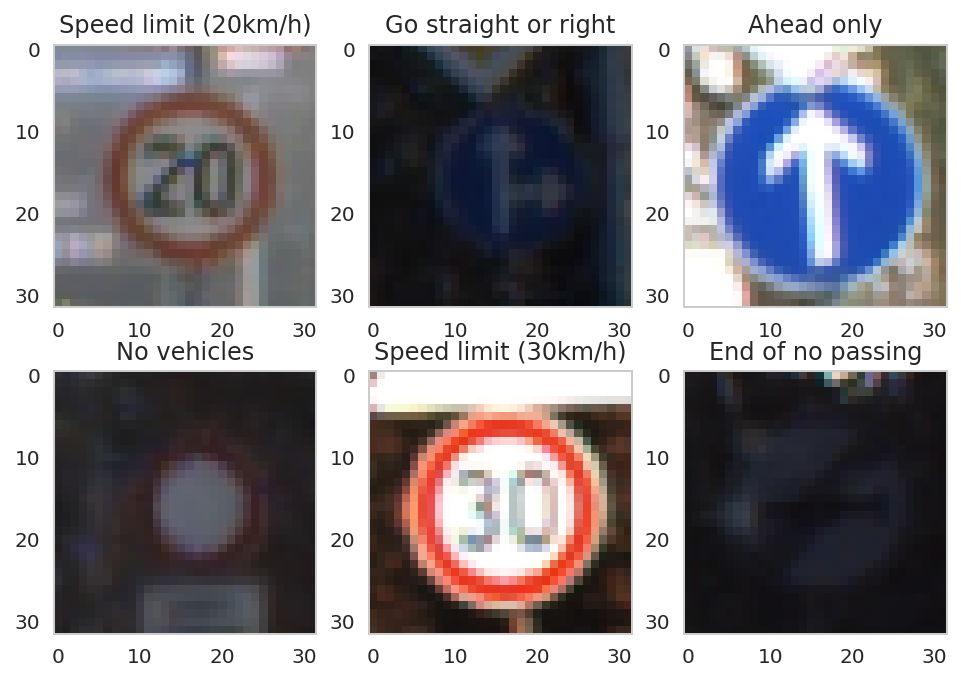

In [8]:
# let's have a look at a few different image to see what they're like
ax = plt.subplot(2,3,1)
ax.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[10000]]['SignName'][y_train[10000]])
ax.grid(False)
ax.imshow(X_train[10000])
ax2 = plt.subplot(2,3,2)
ax2.grid(False)
ax2.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[1000]]['SignName'][y_train[1000]])
ax2.imshow(X_train[1000])
ax3 = plt.subplot(2,3,3)
ax3.grid(False)
ax3.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[20000]]['SignName'][y_train[20000]])
ax3.imshow(X_train[20000])

ax4 = plt.subplot(2,3,4)
ax4.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[30000]]['SignName'][y_train[30000]])
ax4.grid(False)
ax4.imshow(X_train[30000])
ax5 = plt.subplot(2,3,5)
ax5.grid(False)
ax5.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[3000]]['SignName'][y_train[3000]])
ax5.imshow(X_train[3000])
ax6 = plt.subplot(2,3,6)
ax6.grid(False)
ax6.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[200]]['SignName'][y_train[200]])
ax6.imshow(X_train[200])

plt.savefig('examples/train_examples.jpg')

One immediate observation is that the images vary quite a bit in terms of how bright they are-- this is likely to cause issues in training. Image normalisatin is likely to help here, together with histogram equalisation to increase contrast. (to be implemented in the image preprocessing pipelin)

#### Class distribution
it would be useful to see if there are any imbalances in the classes, as these can 
affect accuracy of the training, especially if the validation/test distributions are quite different

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


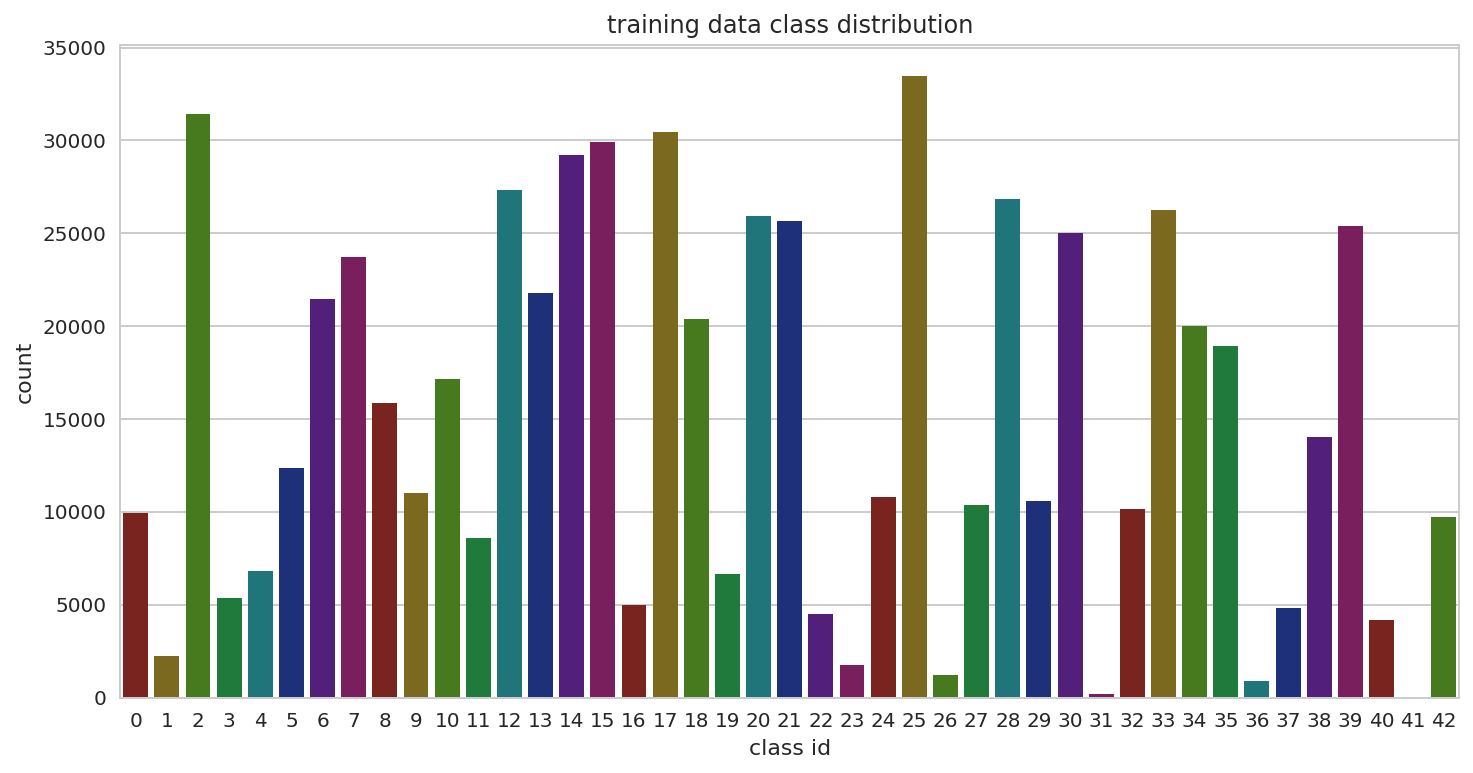

In [13]:
train_class_id, train_class_count = np.unique(y_train, return_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = sns.barplot(train_class_id, train_class_count, palette=sns.hls_palette(8, l=.3, s=.8))
ax.set(xlabel='class id', ylabel='count', title="training data class distribution")
plt.savefig('examples/train_distribution.jpg')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


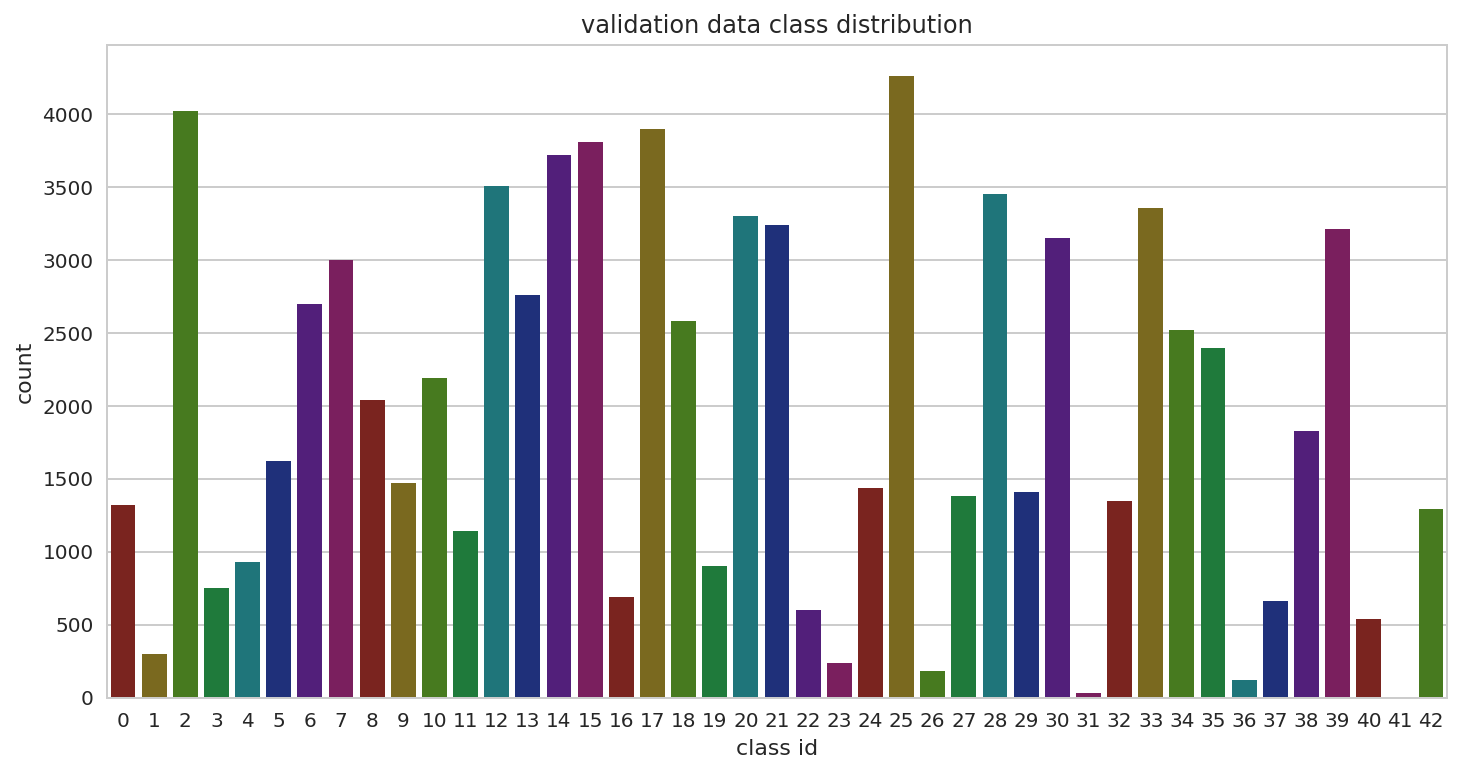

In [14]:
valid_class_id, valid_class_count = np.unique(y_valid, return_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = sns.barplot(valid_class_id, valid_class_count, palette=sns.hls_palette(8, l=.3, s=.8))
ax.set(xlabel='class id', ylabel='count', title="validation data class distribution")
plt.savefig('examples/validation_distribution.jpg')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


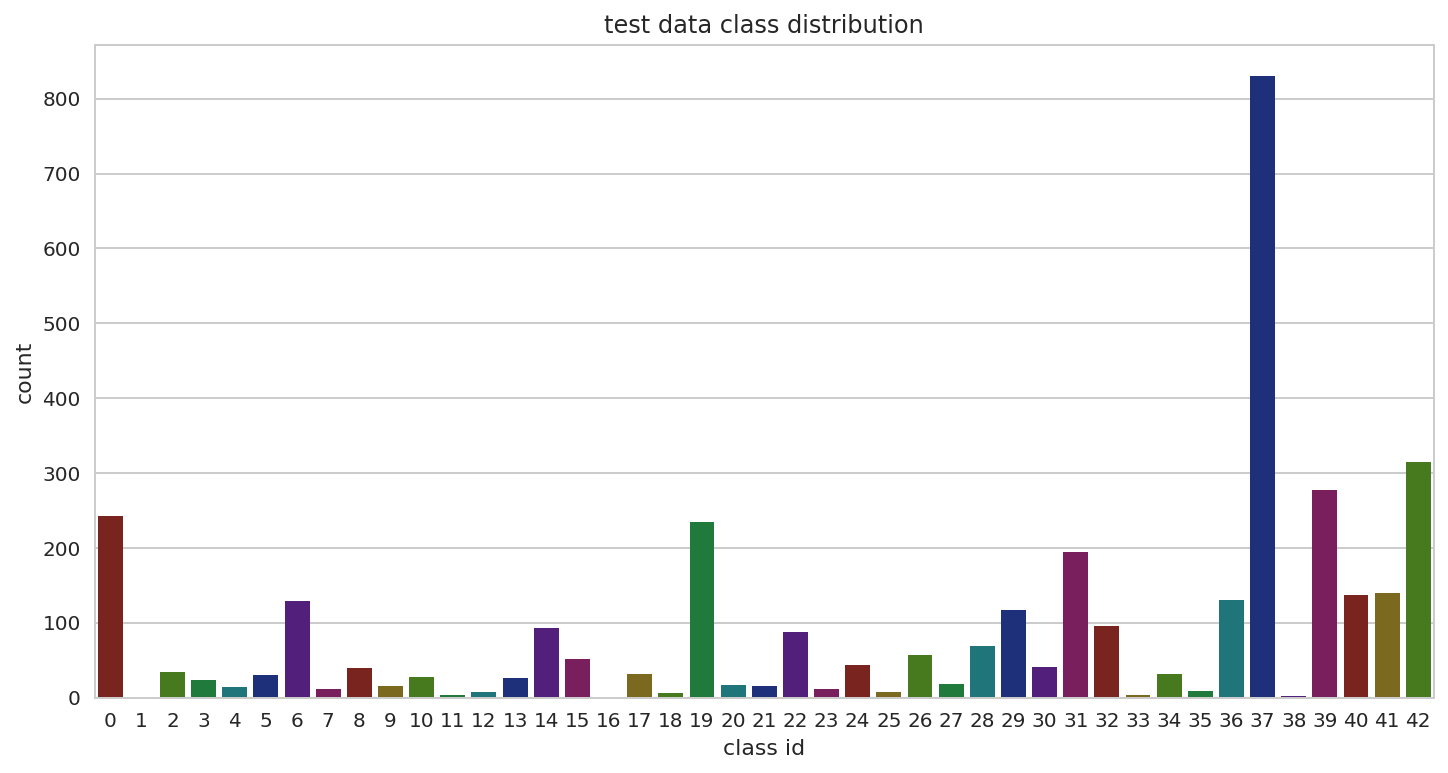

In [15]:
test_class_id, test_class_count = np.unique(y_test, return_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = sns.barplot(test_class_id, test_class_count, palette=sns.hls_palette(8, l=.3, s=.8))
ax.set(xlabel='class id', ylabel='count', title="test data class distribution")
plt.savefig('examples/test_distribution.jpg')

From the above 3 plots, the classes are not very balanced, perhaps reflecting the reality of how common each type of sign there is 'in the wild'. 

The class inbalance could be addressed by weighting in calculating the loss function (e.g. by using the class_weight param in keras) or using image augmentation to generate 'fake' images

The test data has a different distribution to the train/validation data. However, if the model is well generalised this shouldn't be an issue

---
### Step 2: Image preprocessing

The steps are:
1. histogram normalisation: this is done by converting to YUV color channel and normalising the Y (brightness) channel, which leaving the U and V channels which corresponds to color unchanged.
2. normalised the images 
3. Augment data with rotated, shifted, zoomed images using the ImageDataGenerator from keras (this makes the network more robust to the traffic signs being at different positions in the image, or viewed from different angle)

In [50]:
def histogramEqualisation(img):
    original_type = img.dtype
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    equalised = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return equalised.astype(original_type)


def hist(X):
    out = []
    for i in range(len(X)):
        out.append(histogramEqualisation(X[i]))
    return np.array(out)

def normalise(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x)

In [17]:
# historgram equalised
X_train_histogram =  hist(X_train)
X_valid_histogram = hist(X_valid)
X_test_histogram =  hist(X_test)

After histogram equalisation, the images have similar brightness, and also appear a bit 'sharper'

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


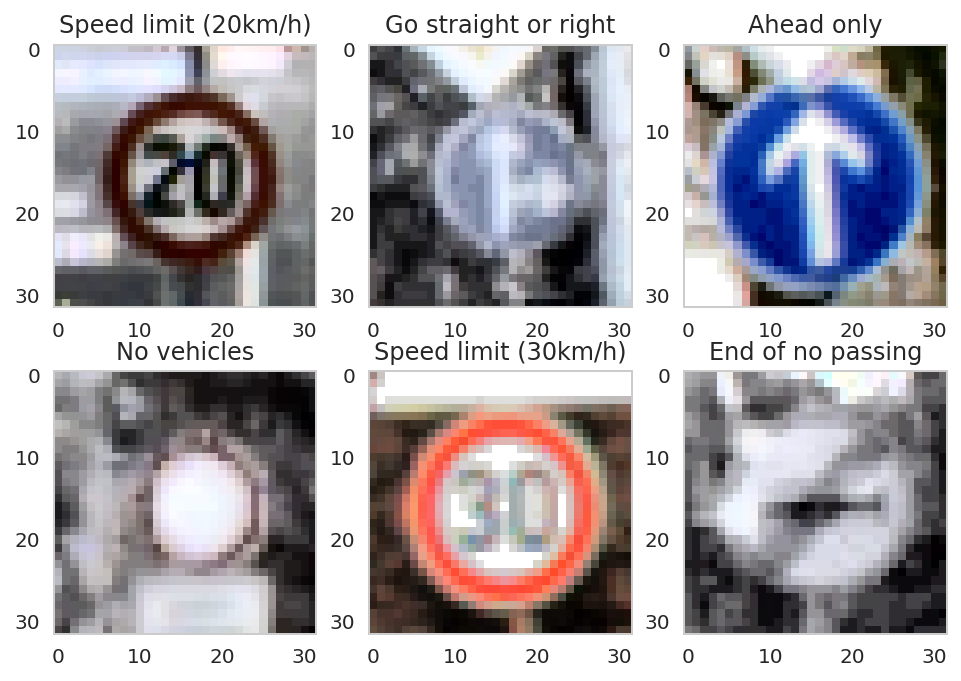

In [18]:
ax = plt.subplot(2,3,1)
ax.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[10000]]['SignName'][y_train[10000]])
ax.grid(False)
ax.imshow(X_train_histogram[10000])
ax2 = plt.subplot(2,3,2)
ax2.grid(False)
ax2.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[1000]]['SignName'][y_train[1000]])
ax2.imshow(X_train_histogram[1000])
ax3 = plt.subplot(2,3,3)
ax3.grid(False)
ax3.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[20000]]['SignName'][y_train[20000]])
ax3.imshow(X_train_histogram[20000])

ax4 = plt.subplot(2,3,4)
ax4.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[30000]]['SignName'][y_train[30000]])
ax4.grid(False)
ax4.imshow(X_train_histogram[30000])
ax5 = plt.subplot(2,3,5)
ax5.grid(False)
ax5.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[3000]]['SignName'][y_train[3000]])
ax5.imshow(X_train_histogram[3000])
ax6 = plt.subplot(2,3,6)
ax6.grid(False)
ax6.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[200]]['SignName'][y_train[200]])
ax6.imshow(X_train_histogram[200])

plt.savefig('examples/train_histo_equalised_examples.jpg')

In [ ]:
mean_hist_train = np.mean(X_train_histogram)
std_hist_train = np.std(X_train_histogram)
min_hist_train = np.min(X_train_histogram)
max_hist_train = np.max(X_train_histogram)

In [ ]:
mean_hist_values = {
    'mean_hist_train': mean_hist_train,
    'std_hist_train': std_hist_train,
    'min_hist_train': min_hist_train,
    'max_hist_train': max_hist_train
}
np.save("data/mean_hist_values.npy", mean_hist_values)

In [ ]:
# normalised

X_train_hist_norm1 = normalise(X_train_histogram, min_hist_train, max_hist_train)
X_valid_hist_norm1 = normalise(X_valid_histogram, min_hist_train, max_hist_train)
X_test_hist_norm1 = normalise(X_test_histogram, min_hist_train, max_hist_train)

np.save('data/X_train_hist_norm1.npy', X_train_hist_norm1)
np.save('data/X_valid_hist_norm1.npy', X_valid_hist_norm1)
np.save('data/X_test_hist_norm1.npy', X_test_hist_norm1)

In [13]:
# data generator:
datagen = image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.)

----

## Step 3:  Model Architectures


In [7]:
# can resume from here rather than from the start 
# run these to load the saved processed training/validation/testing data
X_train_hist_norm1 =np.load('data/X_train_hist_norm1.npy')
X_valid_hist_norm1 =np.load('data/X_valid_hist_norm1.npy')
X_test_hist_norm1 = np.load('data/X_test_hist_norm1.npy')

y_train_cat =np.load('data/y_train_cat.npy')
y_valid_cat =np.load('data/y_valid_cat.npy')
y_test_cat = np.load('data/y_ttest_cat.npy')

hist_norm_values = np.load('data/mean_hist_values.npy').item()

datagen = image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.)

In [14]:
# also define custom keras callback as verbose = 1 crashed the browser
def logger(epoch, logs):
    if epoch %2== 0: 
        print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)


#### LeNet architecture
First, a quick implementation of a simple leNet to act as benchmark. Here, I have used the datagenerator. 
Previous experiments _without_ the generator shows less good results

In [11]:
# first, a quick implementation of a simple leNet to act as benchmark
# making use of the Xavier weight activation
def leNet():
    input_shape = image_shape
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape) )
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape) )
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    return model


In [15]:
#in this run, not using the class weighting
K.clear_session()
batch_size = 32
epochs = 40
leNet_model = leNet()

lehistory = leNet_model.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/lenet_generator.h5', save_best_only=True)
                              ])

0 2.0495653191 0.392999798857 0.700000000216
2 0.60508911541 0.792752665306 0.883673469388
4 0.406454326891 0.863271933131 0.91746031746
6 0.310321016499 0.896520014943 0.950113378685
8 0.267924914411 0.913589470989 0.951473923281
10 0.230033065665 0.924423115634 0.94693877551
12 0.211485121697 0.932469323831 0.966439909297
14 0.198114825517 0.936061381103 0.9589569161
16 0.181430767028 0.941205207046 0.966666666856
18 0.165388251747 0.947096180952 0.970521542166
20 0.161723162823 0.948590476738 0.969387755291
22 0.158268733357 0.950228454841 0.96417233579
24 0.148664849309 0.951923905863 0.965986394747
26 0.149257728749 0.952182533981 0.973922902494
28 0.138008990419 0.956263111009 0.971882086195
30 0.135525845488 0.957470042243 0.972789115646
32 0.131607619154 0.958935601598 0.980725623583
34 0.126033928319 0.960429897411 0.975510204082
36 0.121331996592 0.962556395299 0.981632653061
38 0.120889638501 0.962613868215 0.972562358277


In [33]:
leNet_model = load_model('models/lenet_generator.h5')
# validation accuracy:
lenet_score = leNet_model.evaluate(X_valid_hist_norm1, y_valid_cat, verbose=0)
print(leNet_model.metrics_names[0] + ": "+ str(lenet_score[0]) + "," + leNet_model.metrics_names[1] + ": " 
      +  str(lenet_score[1]))

loss: 0.0637497529705,acc: 0.980725623583


In [34]:
# test accuracy:
lenet_score_test = leNet_model.evaluate(X_test_hist_norm1, y_test_cat, verbose=0)
print(leNet_model.metrics_names[0] + ": "+ str(lenet_score_test[0]) + "," + leNet_model.metrics_names[1] + ": " 
      +  str(lenet_score_test[1]))

loss: 0.148289505554,acc: 0.960015835332


In [21]:
lenet_val_loss = lehistory.history.get('val_loss')
lenet_val_acc = lehistory.history.get('val_acc')
lenet_loss = lehistory.history.get('loss')
lenet_acc = lehistory.history.get('acc')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


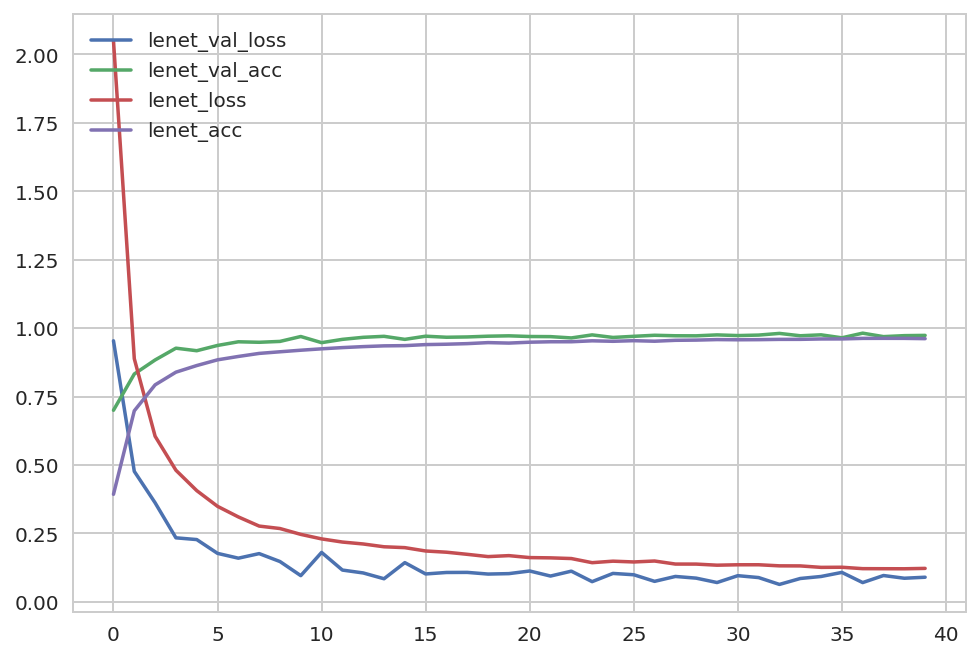

In [22]:
plt.plot(lenet_val_loss)
plt.plot(lenet_val_acc)
plt.plot(lenet_loss)
plt.plot(lenet_acc)
plt.legend(['lenet_val_loss', 'lenet_val_acc', 'lenet_loss', 'lenet_acc'], loc='upper left')
plt.show()

#### VGG inspired archeticture
Just by taking into account the class imbalace, and using a better normalisation, takes the accuracy of the lenet architecture to test accuracy of approx 95%. But can we do better than this, e.g. use a deeper network?

In the following archeticture, I am using the functional api in keras as it gives better flexibility for constructing more
complex networks

In [24]:
def vggLike(n_classes, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=(32,32,3))
    
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(inputs)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)
    
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)
        
    fcblock = Dense(1024, activation='relu', name='fc1')(output2)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)  
    predictions = Dense(n_classes, activation='softmax', name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [25]:
K.clear_session()
batch_size = 32
epochs = 60
vgg_model = vggLike(n_classes)

vgghistory = vgg_model.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/vgglike_generator.h5', save_best_only=True)
                              ])

0 1.03417900742 0.693295784392 0.904081632653
2 0.174345844552 0.944136325756 0.957142857143
4 0.10813036536 0.966407080663 0.991383219955
6 0.0876468402374 0.97313141185 0.974376417234
8 0.0720330307299 0.977901663841 0.973696145314
10 0.0625399839799 0.980746573205 0.991156462585
12 0.0520585172107 0.984137475242 0.975736961451
14 0.0442918410279 0.986235236645 0.995238095238
16 0.0394943676286 0.987930687663 0.972562358277
18 0.0350065702907 0.989310037645 0.983219954838
20 0.0317956172696 0.989827293888 0.991609977324
22 0.0273535848718 0.991005488691 0.986394557823
24 0.0276962025069 0.991465271991 0.992517006803
26 0.024568077148 0.992413575103 0.982766439909
28 0.0246768337418 0.992902094888 0.994557823129
30 0.0249149984778 0.992327365729 0.992290249433
32 0.0216514593737 0.99370671571 0.992970521542
34 0.0177923687234 0.994367654243 0.989342403628
36 0.0193560013254 0.993936607374 0.993650793651
38 0.019582587129 0.994310181354 0.99433106576
40 0.0192914302147 0.994022816748 0

In [31]:
vgg_model = load_model('models/vgglike_generator.h5')
# validation score
vgg_score_validation = vgg_model.evaluate(X_valid_hist_norm1, y_valid_cat, verbose=0)
print(vgg_model.metrics_names[0] + ": "+ str(vgg_score_validation[0]) + "," + vgg_model.metrics_names[1] + ": " 
      +  str(vgg_score_validation[1]))

loss: 0.00652977736898,acc: 0.997959183673


In [32]:
# test score
vgg_score_test = vgg_model.evaluate(X_test_hist_norm1, y_test_cat, verbose=0)
print(vgg_model.metrics_names[0] + ": "+ str(vgg_score_test[0]) + "," + vgg_model.metrics_names[1] + ": " 
      +  str(vgg_score_test[1]))

loss: 0.067434696015,acc: 0.985748218603


In [28]:
vgg_val_loss = vgghistory.history.get('val_loss')
vgg_val_acc = vgghistory.history.get('val_acc')
vgg_loss = vgghistory.history.get('loss')
vgg_acc = vgghistory.history.get('acc')


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


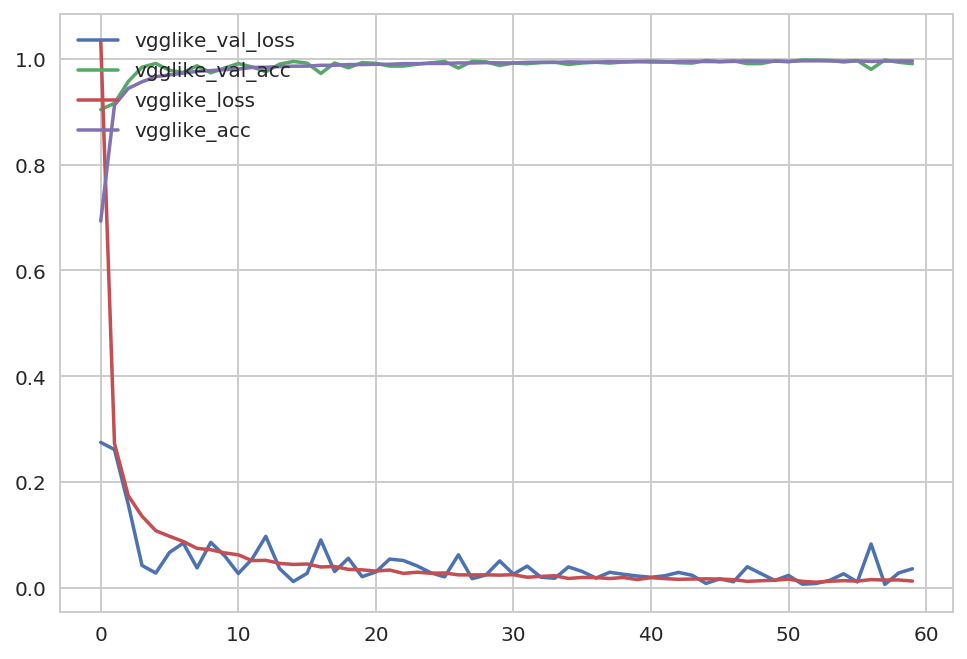

In [29]:
plt.plot(vgg_val_loss)
plt.plot(vgg_val_acc)
plt.plot(vgg_loss)
plt.plot(vgg_acc)
plt.legend(['vgglike_val_loss', 'vgglike_val_acc', 'vgglike_loss', 'vgglike_acc'], loc='upper left')
plt.show()
plt.savefig('examples/vgg_loss_monitoring.jpg')

#### Multiscale cnn
Vgg style networks already achieve ~98% test accuracy, but can a multiscale cnn (e.g. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) do even better? 

In [30]:
# here, I am basing my network off the previous vgglike model, 
# but the output of conv block1 is also fed into the fully connected layer
def mscnn(n_classes, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=(32,32,3))
    
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(inputs)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)
    
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)
    
    output1 = Flatten()(block1)
    
    merged = concatenate([output1, output2])
    
    fcblock = Dense(1024, activation='relu', name='fc1')(merged)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)  
    predictions = Dense(n_classes, activation='softmax', name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [35]:
K.clear_session()
batch_size = 32
epochs = 80
mscnn_model = mscnn(n_classes)

mscnn_history = mscnn_model.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/mscnn_generator.h5', save_best_only=True)
                              ])

0 1.0637804824 0.688353113611 0.863492063681
2 0.146293612835 0.951751487112 0.979591836735
4 0.0979250169717 0.969481881663 0.978458050103
6 0.0795562127354 0.974596971206 0.986848072752
8 0.0588348527522 0.981982240869 0.980725623583
10 0.058517189341 0.982010977327 0.987755102041
12 0.0463372125648 0.986091554382 0.984126984127
14 0.0434466830606 0.986896175177 0.988888889078
16 0.0366246426992 0.988476680392 0.994331065949
18 0.0379400645273 0.988591626196 0.982766439909
20 0.0313807873763 0.990229604299 0.984353741497
22 0.0294872869894 0.991091698037 0.994557823129
24 0.0279753808858 0.99175263657 0.990476190476
26 0.0220024711412 0.992988304262 0.986621315193
28 0.0221981675471 0.993850398027 0.990022675737
30 0.026515834299 0.991781373055 0.99410430839
32 0.0213523007481 0.993706715739 0.984126984127
34 0.0220184454501 0.992930831346 0.993650793651
36 0.0198295802031 0.994051553233 0.972789115646
38 0.0170677905391 0.99468375528 0.967573696145
40 0.0167048143588 0.995172275065 

In [60]:
mscnn_model = load_model('models/mscnn1.h5')
# mscnn_model = load_model('models/mscnn_generator.h5')
# validation score
mscnn_score_validation = mscnn_model.evaluate(X_valid_hist_norm1, y_valid_cat, verbose=0)
print(mscnn_model.metrics_names[0] + ": "+ str(mscnn_score_validation[0]) + "," + mscnn_model.metrics_names[1] + ": " 
      +  str(mscnn_score_validation[1]))

loss: 0.00961355553487,acc: 0.996145124717


In [43]:
# test score
mscnn_score_test = mscnn_model.evaluate(X_test_hist_norm1, y_test_cat, verbose=0)
print(mscnn_model.metrics_names[0] + ": "+ str(mscnn_score_test[0]) + "," + mscnn_model.metrics_names[1] + ": " 
      +  str(mscnn_score_test[1]))

loss: 0.0612041390608,acc: 0.984402216963


In [44]:
mscnn_val_loss = mscnn_history.history.get('val_loss')
mscnn_val_acc = mscnn_history.history.get('val_acc')
mscnn_loss = mscnn_history.history.get('loss')
mscnn_acc = mscnn_history.history.get('acc')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


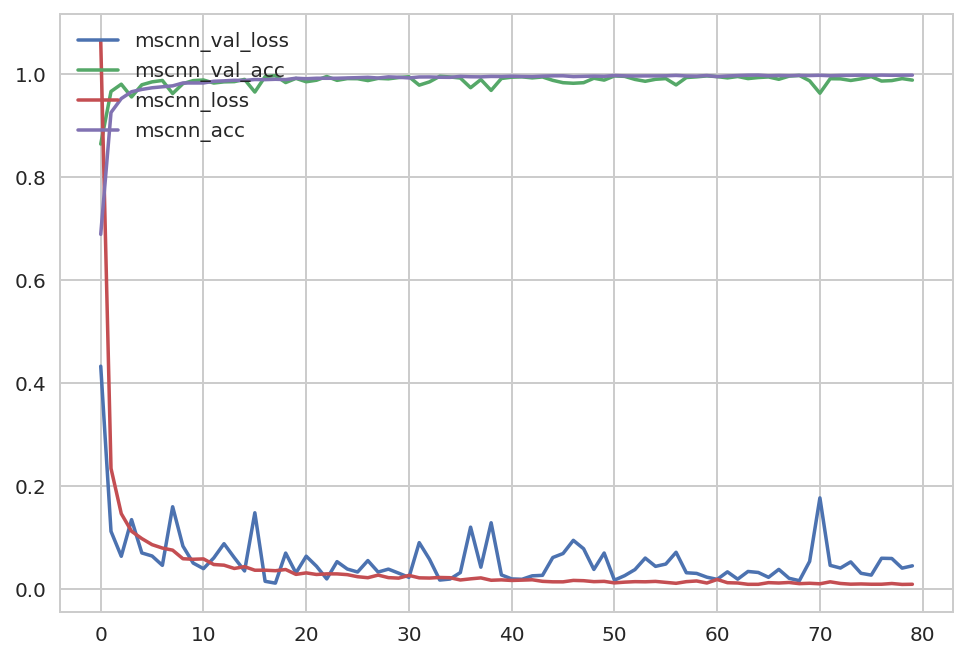

In [45]:
plt.plot(mscnn_val_loss)
plt.plot(mscnn_val_acc)
plt.plot(mscnn_loss)
plt.plot(mscnn_acc)
plt.legend(['mscnn_val_loss', 'mscnn_val_acc', 'mscnn_loss', 'mscnn_acc'], loc='upper left')
plt.show()
plt.savefig('examples/mscnn_loss_monitoring.jpg')

---

## Step 4: Images from the 'wild'

To see how the model performs on new data, 8 images of traffic signs from the internet was used to test the model

### Load and Output the Images

In [73]:
img1 = imread('data/traffic_sign1.jpg')
img2 = imread('data/traffic_sign14.jpg')
img3 = imread('data/traffic_sign0.jpg')
img4 = imread('data/traffic_sign17.jpg')
img5 = imread('data/traffic_sign35.jpg')
img6 = imread('data/traffic_sign2.jpg')
img7 = imread('data/traffic_sign22.jpg')
img8 = imread('data/traffic_sign4.jpg')

imglist = [img1, img2, img3, img4, img5, img6, img7, img8]


In [74]:
min_hist_train = hist_norm_values['min_hist_train']
max_hist_train = hist_norm_values['max_hist_train']

In [78]:
# normalise the images as per the train/validation datasets
test_imgs = []
for i, img in enumerate(imglist):
    test_imgs.append(imresize(img,( 32,32)))
test_imgs_arr = np.array(test_imgs)
test_imgs_classes = np.array([1,14,0, 17,35, 2, 22,4])
test_imgs_arr_hist = hist(test_imgs_arr)
X_test2_hist = normalise(test_imgs_arr_hist, min_hist_train, max_hist_train)
y_test2_cat = utils.to_categorical(test_imgs_classes, n_classes)

np.save('data/X_test2_hist_normed.npy',X_test2_hist )
np.save('data/y_test2_cat.npy', y_test2_cat)


In [ ]:
X_test2_hist = np.load('data/X_test2_hist_normed.npy')
y_test2 = np.load('data/y_test2_cat.npy')

In [76]:
test_predict = mscnn_model.predict(X_test2_hist)
top_probas = []
for i in range(len(test_predict)):
    sorted_arr = np.sort(test_predict[i])[::-1]
    sorted_indexes = np.argsort(test_predict[i])[::-1]
    top_probas.append((sorted_indexes[:5], sorted_arr[:5]))

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


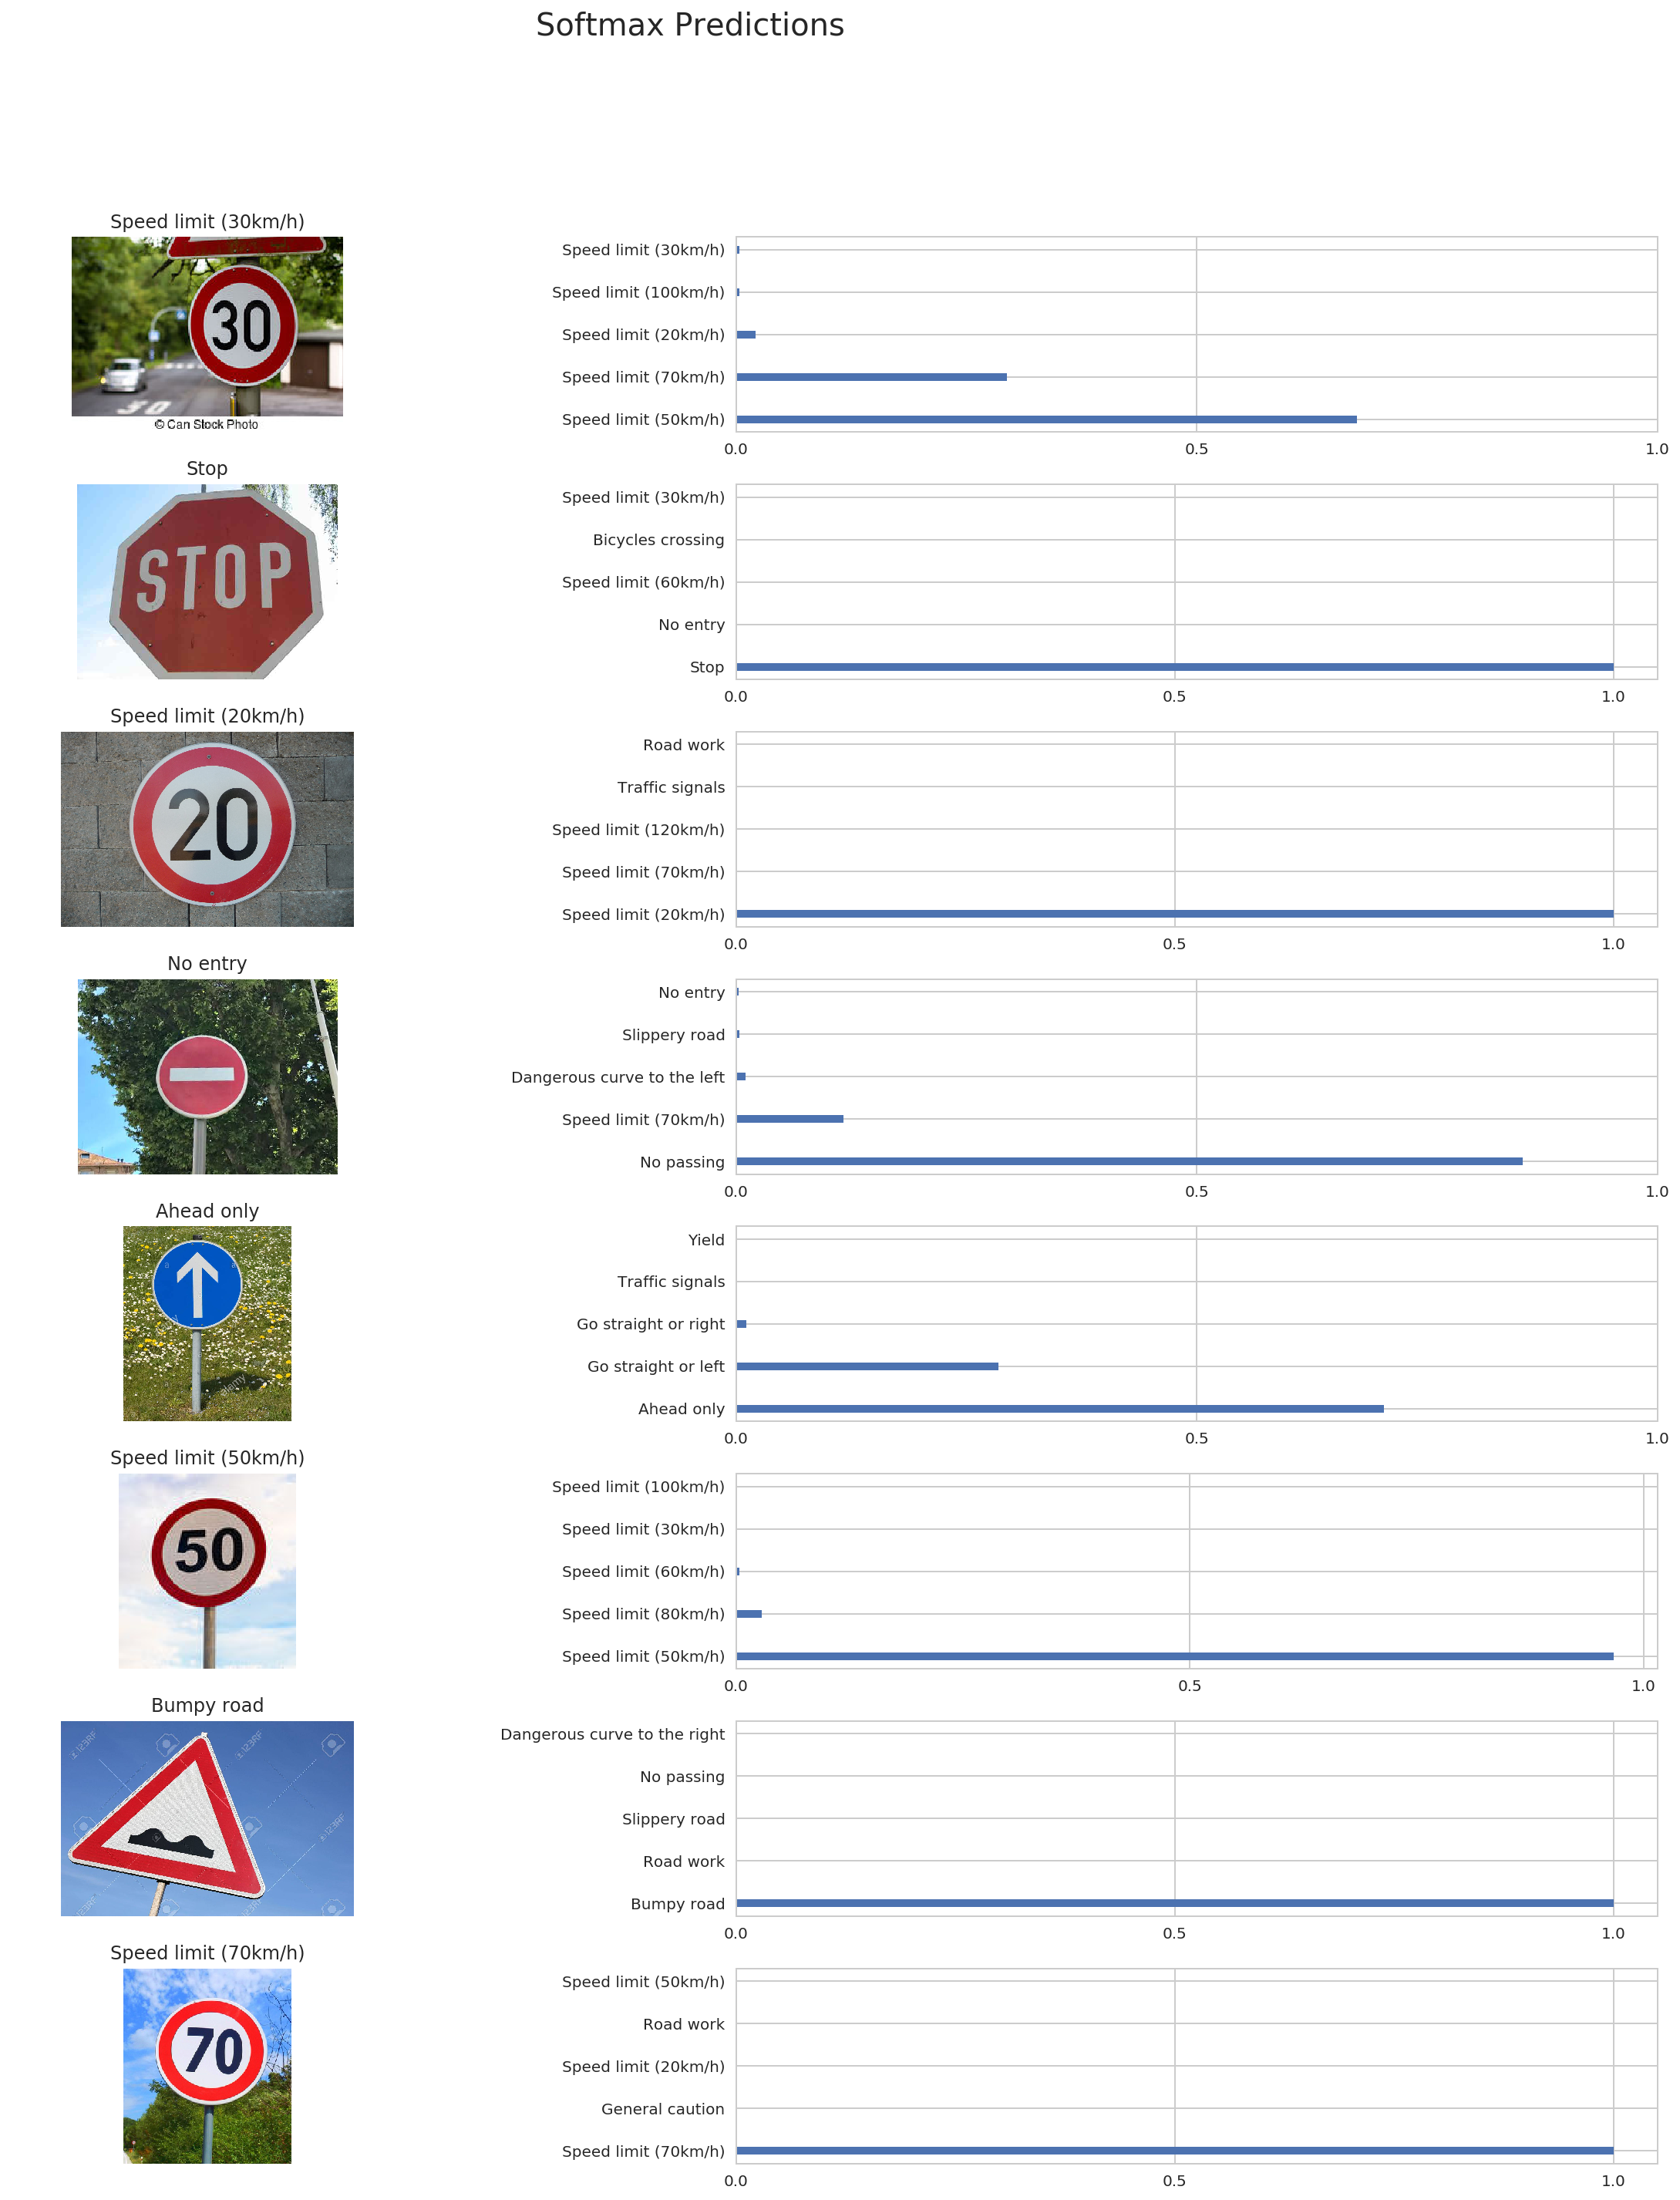

In [77]:
sign_names = signnamesDF['SignName']
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(18,18))
fig.tight_layout()
fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)
n_predictions = 5
margin = 0.05
ind = np.arange(n_predictions)
width = (1. - 2. * margin) / n_predictions

for i in range(len(imglist)):
    predictions = top_probas[i]
    pred_labels = predictions[0]
    probs = predictions[1]
    corret_label = sign_names[test_imgs_classes[i]]
    pred_labels = [sign_names[pred_i] for pred_i in pred_labels]
    axes[i][0].imshow(imglist[i])
    axes[i][0].set_title(corret_label)
    axes[i][0].set_axis_off()

    axes[i][1].barh(ind + margin, probs, width)
    axes[i][1].set_yticks(ind + margin)
    axes[i][1].set_yticklabels(pred_labels)
    axes[i][1].set_xticks([0, 0.5, 1.0])

### Analyze Performance

The model classified 6 out of 8 images correctly. (75% accuracy) In the corrected images, the model is almost 100% sure of the result class. Intetrestingly, the images that were wrongly classified had a really low probability for the correct class